In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

In [2]:
import pandas as pd
import numpy as np
import boto3
import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, DayLocator
import seaborn as sns
import fun_eda, fun_s3

In [6]:
####################################  CARGAMOS BASE ORIGINAL
bucket_name = 'movicovid'
fname = '{}/{}/{}'.format('data', 'dataforgood', 'movimientos_entre_administraciones_08062020.csv')
original_data = fun_s3.abre_file_como_df(bucket_name, fname)

####################################   CAMBIO TIPO DE VARIABLES
original_data['starting_region_name'] = original_data['starting_region_name'].astype('category')
original_data['ending_region_name'] = original_data['ending_region_name'].astype('category')
original_data['fecha'] = pd.to_datetime(original_data['fecha'])
original_data['hr'] = original_data['hora'].str.slice(start=0, stop=2).astype(int)

####################################   SELECCIONAMOS VARIABLES DE INTERES
data = original_data[['difference', 'baseline_people_moving', 'crisis_people_moving', 'starting_region_name', 'percent_change',
                     'ending_region_name', 'length_km', 'hr','fecha']].copy()

####################################  DROP REGISTROS DUPLICADOS
# elimina todos, menos el primero
data.drop_duplicates(subset = ['difference', 'baseline_people_moving', 'crisis_people_moving', 'starting_region_name',
                               'percent_change', 'ending_region_name', 'length_km', 'hr','fecha'], 
                              keep = 'first', inplace = True) 

In [7]:
delegaciones = ["Álvaro Obregón", "Azcapotzalco", "Benito Juárez", "Coyoacán", "Cuajimalpa de Morelos", "Cuauhtémoc",
                "Gustavo A. Madero", "Iztacalco", "Iztapalapa", "La Magdalena Contreras", "Miguel Hidalgo", "Milpa Alta",
                "Tláhuac", "Tlalpan", "Venustiano Carranza", "Xochimilco"]

In [8]:
####################################   TRANSFORMACION DE VARIABLES  ####################################

#### Añado columnas que indican si el Origen/Destino es en CDMX
data = data.assign(ori_cdmx=np.where(data["starting_region_name"].isin(delegaciones), 'CDMX', 'Otro'), 
                   des_cdmx=np.where(data["ending_region_name"].isin(delegaciones), 'CDMX', 'Otro'))

### Añado una columna que contabilice el numero de semanas
data['num_semana'] = data['fecha'].dt.week

### Añado una columna para el dia de la semana
dict_days = {0:'Lunes',1:'Martes',2:'Miércoles',3:'Jueves',4:'Viernes',5:'Sábado',6:'Domingo'}
data['dia_semana'] = data['fecha'].dt.dayofweek.map(dict_days)

### Anado una columna para identificar la ruta
data['ruta'] = data['starting_region_name'].astype(str) + " - " + data['ending_region_name'].astype(str)


# Movicovid

### A. Contexto

El 23 de Marzo, se inicio oficialmente, la Jornada Nacional de Sana distancia, que se planteó inicialmente para el período del 23 de Marzo al 19 de Abril. Las medidas de esta campaña incluyeron la suspensión temporal de actividades escolares, la suspensión temporal de actividades no esenciales, la reprogramación de los eventos de concentración masiva, y el **repliegue familiar en casa**, es decir, el mantenerse en casa tratando de respetar la sana distancia de 1.5 metros entre los miembros de la familia.

  - **23 de Marzo 2020**. Inicia Fase 2 y la Jornada Nacional de Sana Distancia [1](http://www.imss.gob.mx/prensa/archivo/202003/142), [2](https://www.dof.gob.mx/nota_detalle.php?codigo=5590339&fecha=24/03/2020), [3](https://www.gob.mx/salud/prensa/095-inicia-fase-2-por-coronavirus-covid-19).
  - **30 de Marzo 2020**. Declaración de Emergencia Sanitaria [4](https://dof.gob.mx/nota_detalle.php?codigo=5590745&fecha=30/03/2020).
  - **21 de Abril 2020**. Inicia Fase 3 por COVID-19 [5](https://www.gob.mx/salud/prensa/110-inicia-la-fase-3-por-covid-19).  Se extiende la Jornada Nacional de Sana Distancia hasta el 30 de mayo de 2020, [6](https://www.dof.gob.mx/nota_detalle.php?codigo=5592067&fecha=21/04/2020).
  - **1 de Junio 2020**. Concluye la Jornada Nacional de Sana Distancia. Inician actividades los sectores neo-esenciales como minería, construcción e industria automotriz, bajo protocolos de seguridad enfocados a evitar contagios en los centros de trabajo [7](http://www.imss.gob.mx/prensa/archivo/202005/356).

Por su parte, y acorde con la política nacional de *#QuédateEnCasa* y *#SanaDistancia*, el Gobierno de la Ciudad de México también suspendió actividades y establecimientos del 23 de Marzo al 19 de Abril, [8](https://www.cdmx.gob.mx/portal/articulo/cierre-temporal-de-actividades-y-establecimientos-por-covid-19). El 31 de Marzo, se dio a conocer que únicamente se mantendrían activos los establecimientos relacionados con servicios de salud, alimentación e indispensables, como gasolineras y bancos, cerrando centros comerciales y otros estableciomientos considerados no escenciales, [9](https://www.cdmx.gob.mx/portal/articulo/cierre-de-centros-comerciales-por-emergencia-sanitaria). El 24 de abril, se cerraron el 20% de las estaciones del Metro, Metrobús y Tren Ligero, y el Hoy No Circula se aplicó para todos los vehículos particulares, con algunas excepciones, [10](https://www.cdmx.gob.mx/portal/articulo/nuevas-medidas-para-la-fase-3-por-covid-9). El 22 de Mayo, se dio a conocer el plan gradual hacia la nueva normalidad, [11](https://www.cdmx.gob.mx/portal/articulo/plan-gradual-hacia-la-nueva-normalidad), [12](https://covid19.cdmx.gob.mx/storage/app/media/plan%20gradual%20hacia%20la%20nueva%20normalidad%20en%20la%20ciudad%20de%20mexico/plangradualhacialanuevanormalidadenlaciudaddemexico20.pdf). El 1 de Julio, se retomaron actividades económicas esenciales, [13](https://www.cdmx.gob.mx/portal/articulo/lineamientos-para-industrias-que-retoman-actividades).


Sin embargo, algunas fuentes periodísticas han afirmado que parte de la población no pudo quedarse en casa durante el período, [14](https://www.elfinanciero.com.mx/nacional/en-mexico-apenas-35-ha-respetado-el-quedate-en-casa-revela-google), [15](https://www.animalpolitico.com/2020/04/municipios-cumplen-quedate-en-casa-covid-19/).


### B. Objetivo

Caracterizar a la población que lamentablemente, no pudo cumplir los lineamientos de #SusanaDistancia y #QuedateEnCasa sugeridos por la Secretaría de Salud.


*Otros datos de movilidad semanales: [Apple](https://www.apple.com/covid19/mobility), [Google](https://www.gstatic.com/covid19/mobility/2020-06-07_MX_Mobility_Report_en.pdf).


### C. Preguntas a investigar

### 1. De las rutas


#### 1.1. Definición de rutas
   
   - ¿Consideramos todas las trayectorias origen-destino como ruta? ¿las más transitadas?
   - Rutas de corto alcance vs. largo alcance (km a la redonda)
   - ¿Qué se puede inferir de los movimientos que ocurren con mayor/menor frecuencia?
     - 80-20 de las rutas
     - 90-10 de las rutas

#### 1.2. Características de las rutas en el tiempo
       
   - ¿Se debe hacer un baseline para comparar?
   - Rutas sin cambios, rutas con cambios

#### 1.3. Características de las rutas en cuanto a su destino y origen

   - Rutas de trabajo (zona habitacional -> trabajo), de recreación (zona habitacional -> espacios públicos), de emergencias (zona habitacional -> hospitales)
   - Rutas por actividad económica
   - Rutas en transporte público, Uber/Lyft, taxis, particular

Existen 284,495 registros de rutas los cuales se distribuyen de la siguiente manera:

In [9]:
total_rutas = len(data)
rutas = data.groupby(['ori_cdmx', 'des_cdmx']).size()
rutas = rutas.reset_index()  
rutas.columns = ['Origen', 'Destino', 'Rutas']
rutas = rutas.pivot_table(index='Origen', columns='Destino', values='Rutas')
rutas_prop = rutas.divide(total_rutas) * 100

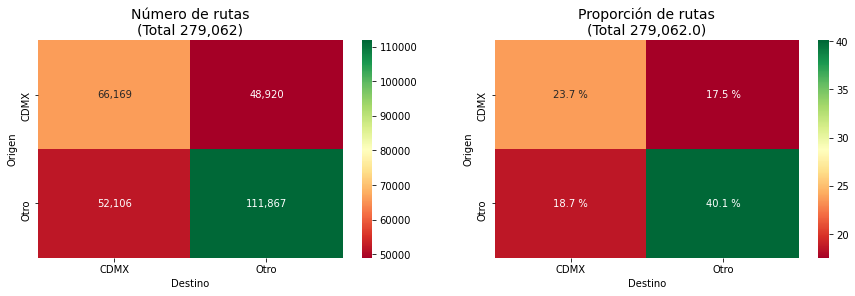

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

sns.heatmap( rutas, annot=True, fmt='0,.0f', cmap='RdYlGn', ax=ax[0])
ax[0].set_title('Número de rutas\n(Total {:0,.0f})'.format(total_rutas), fontsize=14)

sns.heatmap( rutas_prop, annot=True, fmt='0,.1f', cmap='RdYlGn', ax=ax[1])
ax[1].set_title('Proporción de rutas\n(Total {:0,.1f})'.format(total_rutas), fontsize=14)
for t in ax[1].texts: t.set_text(t.get_text() + " %")


plt.show()

Separados por hora, la distribución es así:

In [11]:
ruta_hora = data.groupby(['ori_cdmx', 'des_cdmx', 'hr']).size()
ruta_hora = ruta_hora.reset_index()  
ruta_hora.columns = ['Origen', 'Destino', 'hr', 'Rutas']

ruta0 = ruta_hora[ruta_hora['hr']==0].pivot_table(index='Origen', columns='Destino', values='Rutas')
ruta8 = ruta_hora[ruta_hora['hr']==8].pivot_table(index='Origen', columns='Destino', values='Rutas')
ruta16 = ruta_hora[ruta_hora['hr']==16].pivot_table(index='Origen', columns='Destino', values='Rutas')

ruta0_prop = ruta0.divide(ruta0.values.sum())*100
ruta8_prop = ruta8.divide(ruta8.values.sum())*100
ruta16_prop = ruta16.divide(ruta16.values.sum())*100

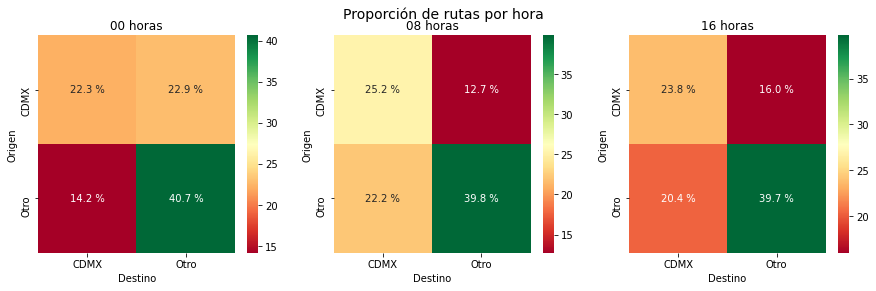

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

sns.heatmap( ruta0_prop, annot=True, fmt='0,.1f', cmap='RdYlGn', ax=ax[0])
ax[0].set_title('00 horas')
for t in ax[0].texts: t.set_text(t.get_text() + " %")

sns.heatmap( ruta8_prop, annot=True, fmt='0,.1f', cmap='RdYlGn', ax=ax[1])
ax[1].set_title('08 horas')
for t in ax[1].texts: t.set_text(t.get_text() + " %")

sns.heatmap( ruta16_prop, annot=True, fmt='0,.1f', cmap='RdYlGn', ax=ax[2])
ax[2].set_title('16 horas')
for t in ax[2].texts: t.set_text(t.get_text() + " %")

fig.suptitle('Proporción de rutas por hora', fontsize=14)
plt.show()
#plt.tight_layout()

Del número de personas que transitan las rutas

In [13]:
ruta_hora = data.groupby(['ori_cdmx', 'des_cdmx', 'hr']).sum()['crisis_people_moving']
ruta_hora = ruta_hora.reset_index()  
ruta_hora.columns = ['Origen', 'Destino', 'hr', 'Rutas']

ruta0 = ruta_hora[ruta_hora['hr']==0].pivot_table(index='Origen', columns='Destino', values='Rutas')
ruta8 = ruta_hora[ruta_hora['hr']==8].pivot_table(index='Origen', columns='Destino', values='Rutas')
ruta16 = ruta_hora[ruta_hora['hr']==16].pivot_table(index='Origen', columns='Destino', values='Rutas')

ruta0_prop = ruta0.divide(ruta0.values.sum())*100
ruta8_prop = ruta8.divide(ruta8.values.sum())*100
ruta16_prop = ruta16.divide(ruta16.values.sum())*100

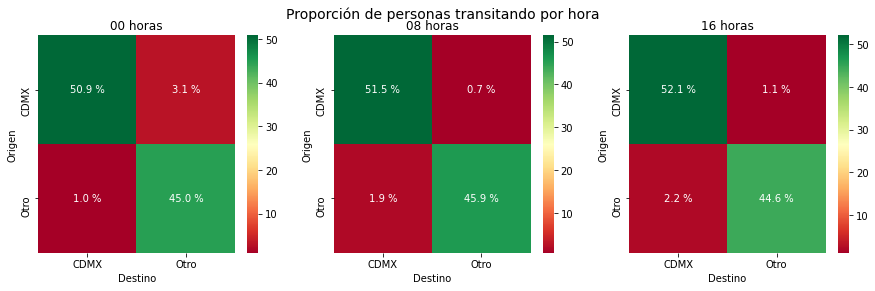

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

sns.heatmap( ruta0_prop, annot=True, fmt='0,.1f', cmap='RdYlGn', ax=ax[0])
ax[0].set_title('00 horas')
for t in ax[0].texts: t.set_text(t.get_text() + " %")

sns.heatmap( ruta8_prop, annot=True, fmt='0,.1f', cmap='RdYlGn', ax=ax[1])
ax[1].set_title('08 horas')
for t in ax[1].texts: t.set_text(t.get_text() + " %")

sns.heatmap( ruta16_prop, annot=True, fmt='0,.1f', cmap='RdYlGn', ax=ax[2])
ax[2].set_title('16 horas')
for t in ax[2].texts: t.set_text(t.get_text() + " %")

fig.suptitle('Proporción de personas transitando por hora', fontsize=14)
plt.show()

Rutas únicas según Origen-Destino

In [15]:
print("Existen {:,.0f} rutas únicas". format(len(data['ruta'].unique())))

Existen 1,571 rutas únicas


Rutas únicas según Origen-Destino y Hora

In [16]:
print("{:,.0f} ruta unicas a las 00 horas".format(len(data[data['hr']==0]['ruta'].unique())))
print("{:,.0f} ruta unicas a las 08 horas".format(len(data[data['hr']==8]['ruta'].unique())))
print("{:,.0f} ruta unicas a las 16 horas".format(len(data[data['hr']==16]['ruta'].unique())))

1,438 ruta unicas a las 00 horas
1,206 ruta unicas a las 08 horas
1,316 ruta unicas a las 16 horas


### 2. De la población

#### 2.1. Características de la población que mantuvo rutas constantes durante la jornada de #SusanaDistancia

   - Población por tipos de rutas: características socio-demográficas, niveles de pobreza
  

#### 2..2 Características de la población que tuvo rutas durante fechas que presentaron picos de conteo de casos, o 15 días antes a esas fechas

   - 

#### 2.3 Identificar correlaciones entre rutas y casos de COVID-19

   - Rutas vs nuevos casos reportados 
   - Rutas vs defunciones

### D. Recomendaciones
   -¿Qué recomendaciones de política de movilidad se pueden sugerir dadas las respuestas a las preguntas anteriores? 
